In [1]:
import sqlite3
import pandas as pd
import math
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as hier

In [2]:
def calculate_distance(lat1, lon1):
    # Radius of the Earth in kilometers
    earth_radius = 6371

    # Convert latitude and longitude to radians
    lat1_rad = math.radians(lat1)
    lon1_rad = math.radians(lon1)
    lat2_rad = math.radians(44.4914)
    lon2_rad = math.radians(20.2744)

    # Calculate the differences between the latitudes and longitudes
    d_lat = lat2_rad - lat1_rad
    d_lon = lon2_rad - lon1_rad

    # Apply the Haversine formula
    a = math.sin(d_lat/2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(d_lon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    distance = earth_radius * c

    return distance

In [3]:
values = ["SUT", "PSUT", "PR", "VPR"]

mapping = {
    "SUT": 0,
    "PSUT": 0.25,
    "PR": 0.5,
    "VPR": 0.75
}

# Connect to the database
conn = sqlite3.connect('db_prodaja-stanova_beograd.db')

# Create a cursor object
cursor = conn.cursor()
df = pd.read_sql_query("SELECT * FROM mytable", conn)

# Execute a SELECT query
cursor.execute("SELECT * FROM mytable")

X_data = list()
Y_data = list()
full_data = list()

# Fetch and print rows one by one
row1 = cursor.fetchone()
row = cursor.fetchone()
while row is not None:
    coordinates = row[4]
    latitude, longitude = coordinates.split(',')
    distance = calculate_distance(float(latitude), float(longitude))

    broj_soba = row[5]

    if broj_soba == None:
        row = cursor.fetchone()
        continue
    broj_soba = float(broj_soba) if broj_soba != '5+' else 5.0

    kvadratura = float(row[6])
    if kvadratura == None:
        row = cursor.fetchone()
        continue

    sprat = row[7]
    if sprat == None:
        row = cursor.fetchone()
        continue
    if sprat in values:
        sprat = mapping[sprat]
    else:
        sprat = float(sprat)
    sprat = math.log2(sprat + 1)

    tip_gradnje = row[8]
    tip_gradnje = 1 if tip_gradnje == 'Novogradnja' else 0
    uknjizen = float(row[9])
    lift = float(row[10])
    garaza = float(row[11])
    terasa = float(row[12])
    pdv = float(row[13])
    cena = float(row[16])

    row_x_data = [distance, broj_soba, kvadratura, sprat, tip_gradnje, uknjizen, lift, garaza, terasa, pdv]
    row_full_data = [distance, broj_soba, kvadratura, sprat, tip_gradnje, uknjizen, lift, garaza, terasa, pdv, cena]
    full_data.append(row_full_data)
    X_data.append(row_x_data)
    Y_data.append(cena)

    row = cursor.fetchone()

# Close the connection
conn.close()

In [4]:
header = ['distance', 'broj_soba', 'kvadratura', 'sprat', 'tip_gradnje', 'uknjizen', 'lift', 'garaza', 'terasa', 'pdv']
# new_header = ['distance', 'kvadratura', 'broj_soba']
new_header = ['distance', 'kvadratura', 'broj_soba']

df_x = pd.DataFrame(X_data, columns=header)

X_data_new = df_x[new_header] 


C:\Users\busketi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\busketi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\busketi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\U

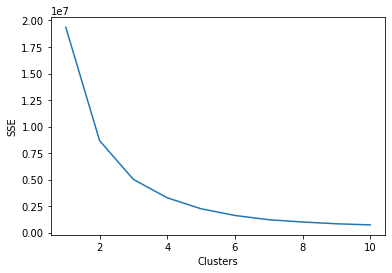

In [5]:
wcss = []
for i in range(1,11):
    k_means = KMeans(n_clusters=i,init='k-means++', random_state=42)
    k_means.fit(X_data_new)
    wcss.append(k_means.inertia_)
#plot elbow curve
plt.plot(np.arange(1,11),wcss)
plt.xlabel('Clusters')
plt.ylabel('SSE')
plt.show()

Analizom SSE (Sum of Squared Errors) krive, primećujemo da nagib najviše varira kada se broj klastera postavi na 3. Stoga, kao optimalan broj klastera, biramo 3.

In [6]:
k_means_optimum = KMeans(n_clusters = 3, init = 'k-means++',  random_state=42)
y = k_means_optimum.fit_predict(X_data_new)
X_data_new['cluster'] = y

C:\Users\busketi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\busketi\AppData\Local\Temp/ipykernel_22544/1117952808.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_data_new['cluster'] = y


In [7]:
data1 = X_data_new[X_data_new.cluster==0]
data2 = X_data_new[X_data_new.cluster==1]
data3 = X_data_new[X_data_new.cluster==2]

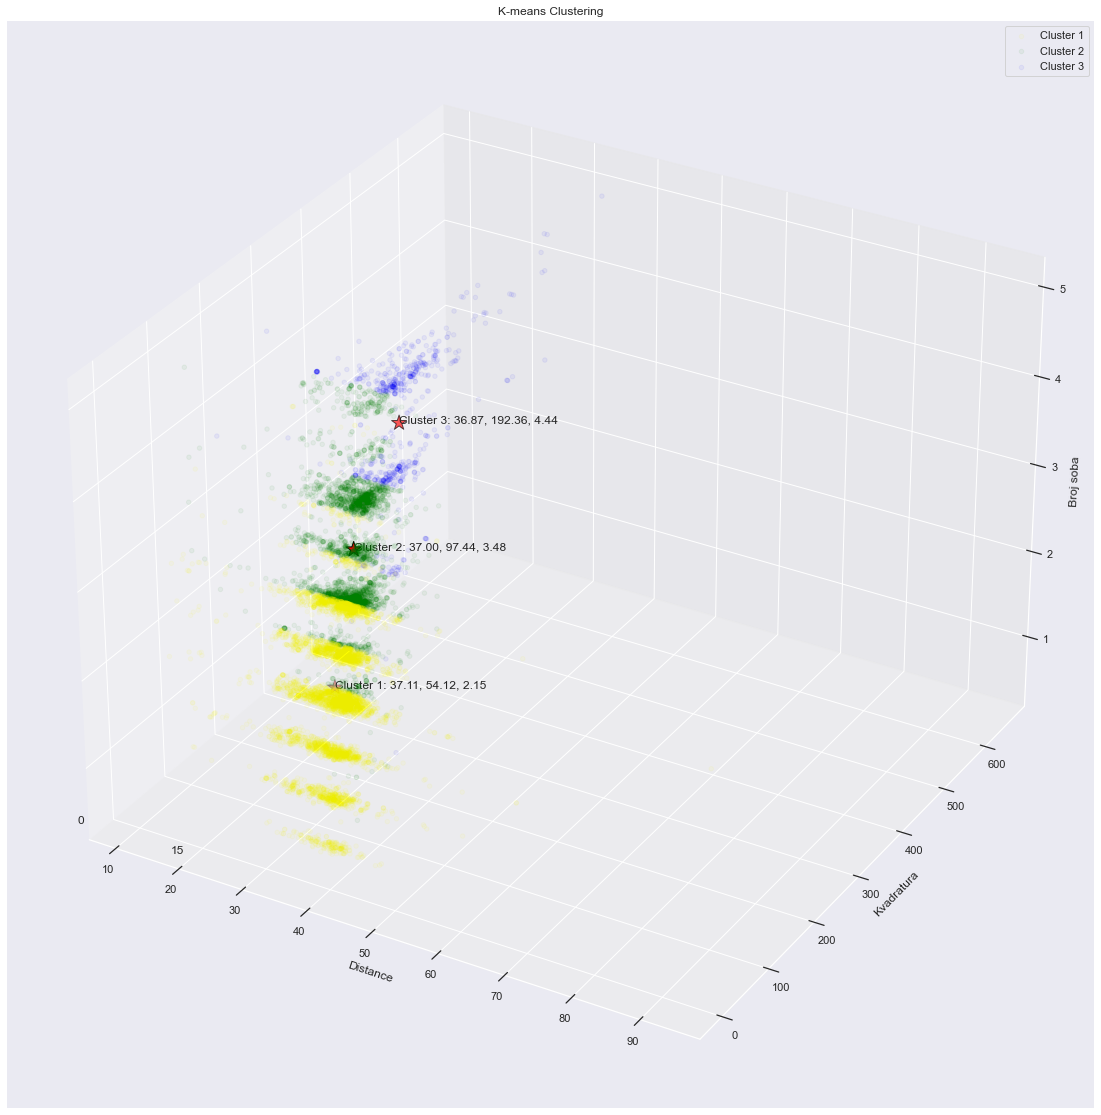

In [19]:
fig = plt.figure(figsize=(20, 20))
kplot = fig.add_subplot(111, projection='3d')

# Plotting the data points for each cluster
kplot.scatter3D(data1.distance, data1.kvadratura, data1.broj_soba, c='yellow', label='Cluster 1', alpha=0.05)
kplot.scatter3D(data2.distance, data2.kvadratura, data2.broj_soba, c='green', label='Cluster 2', alpha=0.05)
kplot.scatter3D(data3.distance, data3.kvadratura, data3.broj_soba, c='blue', label='Cluster 3', alpha=0.05)

# Plotting the cluster centers
kplot.scatter3D(k_means_optimum.cluster_centers_[:,0], k_means_optimum.cluster_centers_[:,1], k_means_optimum.cluster_centers_[:,2], s=250, marker='*',
    c='red', edgecolor='black')

# Adding labels and title
kplot.set_xlabel('Distance')
kplot.set_ylabel('Kvadratura')
kplot.set_zlabel('Broj soba')
# Printing the values on the axes
kplot.text(0, -2, 0, '0')
kplot.text(15, -2, 0, '15')
kplot.text(0, -2, 15, '15')
plt.legend()
plt.title("K-means Clustering")
# Printing the values of cluster centers
cluster_centers = k_means_optimum.cluster_centers_
for i in range(len(cluster_centers)):
    x, y, z = cluster_centers[i]
    label = f"Cluster {i+1}: {x:.2f}, {y:.2f}, {z:.2f}"
    kplot.text(x, y, z, label)

# Display the plot
plt.show()

Analizirajući prikazane podatke, primećujemo da klasteri nemaju jaku vezu sa promenljivom "Distanca", budući da su vrednosti distance veoma bliske između klastera. Međutim, uočavamo da model pretežno deli klastera na osnovu karakteristika "Kvadratura" i "Broj soba". Ova posmatranja ukazuju na izraženu zavisnost između ove dve promenljive, što je očekivano.

Text(0, 0.5, 'Euclidean Distance')

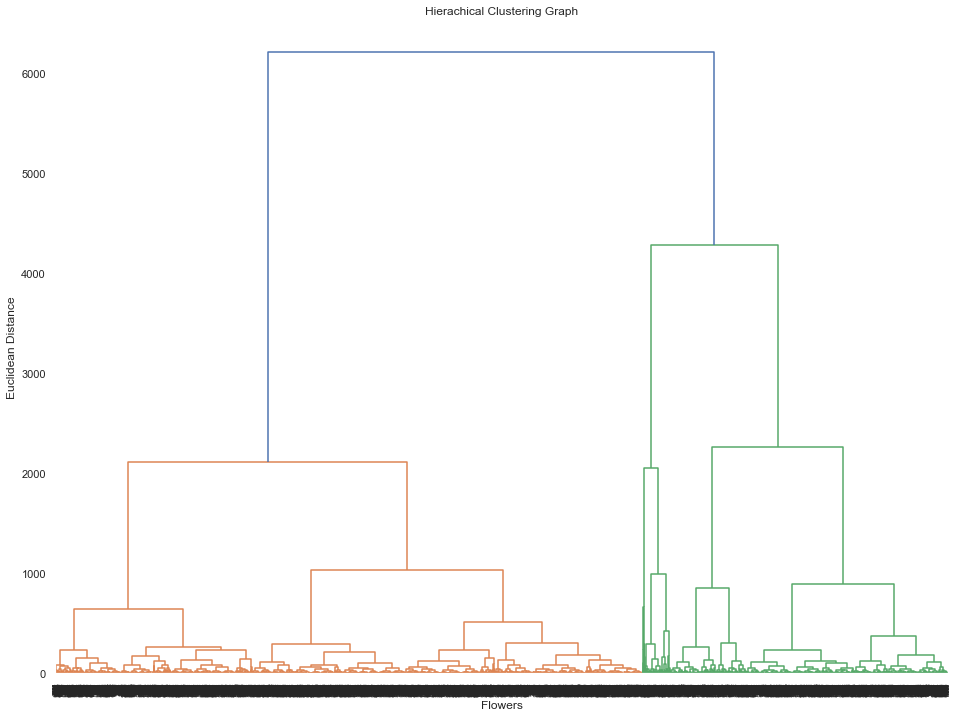

In [13]:
plt.figure(figsize=(16,12))
# Fit the heirachical graph
heirachical_graph=hier.dendrogram(hier.linkage(X_data_new, method='ward')) #method='ward' uses the Ward variance minimization algorithm
# Add titles and labels
plt.title('Hierachical Clustering Graph')
plt.xlabel('Flowers')
plt.ylabel('Euclidean Distance')

Iz prikazanog hijerarhijskog grafa vidimo da se podaci grupišu u tri klastera koji su sličnih površina. Ova informacija je u skladu sa SSE krivom koju smo ranije analizirali, gde smo primetili da se nagib menja najviše za broj klastera 3.

Takođe, hijerarhijski graf jasno prikazuje povezanost između klastera kroz vertikalne linije koje povezuju grane. Ove linije formiraju klaster i ukazuju na sličnost između podataka unutar istog klastera, kao i udaljenost između podataka u različitim klasterima.

SSE kriva pruža kvantitativnu meru za odabir broja klastera, dok hijerarhijski graf pruža vizuelnu reprezentaciju povezanosti između podataka.